In [1]:
import os
import sys
import gym
from gym import wrappers, logger
import gridworld
import random
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib 

matplotlib.use("TkAgg")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from collections import namedtuple, deque

## utils

In [3]:
Transition = namedtuple('Transition', ('state', 'next_state', 'action', 'reward', 'mask'))


class Memory(object):
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
        self.capacity = capacity

    def push(self, state, next_state, action, reward, mask):
        self.memory.append(Transition(state, next_state, action, reward, mask))

    def sample(self, batch_size):
        transitions = random.sample(self.memory, batch_size)
        batch = Transition(*zip(*transitions))
        return batch

    def __len__(self):
        return len(self.memory)


In [4]:
def get_action(state, online_net, epsilon, env):
    if np.random.rand() <= epsilon:
        return env.action_space.sample()
    else:
        return online_net.get_action(state)

def update_target_model(online_net, target_net):
    target_net.load_state_dict(online_net.state_dict())

In [5]:
class   FeaturesExtractor(object):
    def        __init__(self,outSize):
        super().__init__()
        self.outSize=outSize*3
    def __call__(self, obs):
        state=np.zeros((3,np.shape(obs)[0],np.shape(obs)[1]))
        state[0]=np.where(obs == 2,1,state[0])
        state[1]=np.where(obs == 4,1,state[1])
        state[2]=np.where(obs == 6,1,state[2])
        return  state.reshape(1,-1)

## DQN

In [67]:
class QNet(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(QNet, self).__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs

        self.fc1 = nn.Linear(num_inputs, 256)
        self.fc2 = nn.Linear(256, 30)
        self.fc3 = nn.Linear(30, num_outputs)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        qvalue = self.fc3(x)
        return qvalue

    @classmethod
    def train_model(cls, online_net, target_net, optimizer, batch):
        states = torch.stack(batch.state)
        next_states = torch.stack(batch.next_state)
        actions = torch.Tensor(batch.action).float()
        rewards = torch.Tensor(batch.reward)
        masks = torch.Tensor(batch.mask)

        pred = online_net(states).squeeze(1)
        next_pred = target_net(next_states).squeeze(1)

        pred = torch.sum(pred.mul(actions), dim=1)

        target = rewards + masks * gamma * next_pred.max(1)[0]

        loss = F.mse_loss(pred, target.detach())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss

    def get_action(self, input):
        qvalue = self.forward(input)
        _, action = torch.max(qvalue, 1)
        return action.numpy()[0]

###  hyper parameters

In [92]:
gamma = 0.99
batch_size = 64
lr = 0.0001
update_target = 20
replay_memory_capacity = 1000
count_epsds = 500
epsilon = 1.0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


##### train 

In [93]:
env_name = "gridworld-v0"


env = gym.make(env_name)
env.seed(0)
torch.manual_seed(0)
# log file plusieurs scenarios
outdir = 'gridworld-v0/random-agent-results'
envm = wrappers.Monitor(env, directory=outdir, force=True , video_callable=False )
env.setPlan("gridworldPlans/plan1.txt", {0: -0.1, 3: 1, 4: 1, 5: -1, 6: -1})
env.seed()  # randomness init

num_actions = env.action_space.n
Phi_s = FeaturesExtractor(num_actions)
num_inputs = Phi_s(env.reset()).shape[1]

online_net = QNet(num_inputs, num_actions)
target_net = QNet(num_inputs, num_actions)
update_target_model(online_net, target_net)
optimizer = optim.Adam(online_net.parameters(), lr=lr)

online_net.to(device)
target_net.to(device)
online_net.train()
target_net.train()
memory = Memory(replay_memory_capacity)

steps = 0

nbr_actions_list, score_list, loss_list = [],[],[]

for e in range(count_epsds):
    
    done = False
    score = 0
    state = env.reset()
    state = torch.Tensor(state).to(device)
    state = torch.Tensor(Phi_s(state))
    nbr_actions = 0
    avg_loss = 0

    
    while not done:
            
        steps += 1


        action = get_action(state, online_net, epsilon, env)
        next_state, reward, done, _ = env.step(action)
        nbr_actions += 1
        next_state = torch.Tensor(Phi_s(next_state))

        mask = 0 if done else 1
        action_one_hot = np.zeros(4)
        action_one_hot[action] = 1
        memory.push(state, next_state, action_one_hot, reward, mask)
        score += reward
        state = next_state
        
        if ( e % 100 ):
            env.render(0.0001)
        
        if steps > replay_memory_capacity:

            epsilon -= 0.00005
            epsilon = max(epsilon, 0.01)
    
            batch = memory.sample(batch_size)
            loss = QNet.train_model(online_net, target_net, optimizer, batch)
            
            if steps % update_target == 0 :
                update_target_model(online_net, target_net)

            
            avg_loss += loss
    
    epsilon -=0.02
    epsilon = max(epsilon, 0.01)
    score_list.append(score)
    
    if ( e % 50 == 0 and e > 0  ):
        optimizer.param_groups[0]["lr"] /= 2 
        
    nbr_actions_list.append(nbr_actions)
    if ( steps > replay_memory_capacity ) :
        loss_list.append(avg_loss/nbr_actions)
        print('episode {}| score: {:.4f}| Avg Loss: {:.4f}| epsilon_greedy : {:.2f}'.format(e, score,
                                                                               avg_loss/nbr_actions, epsilon))
    else : 
        print('episode {}| score: {:.4f}| epsilon_greedy : {:.2f}'.format(e, score, epsilon))
        
    
       

episode 0| score: -1.5000| epsilon_greedy : 0.98
episode 1| score: -1.1000| epsilon_greedy : 0.96
episode 2| score: -0.7000| epsilon_greedy : 0.94
episode 3| score: -1.0000| epsilon_greedy : 0.92
episode 4| score: -1.0000| epsilon_greedy : 0.90
episode 5| score: -3.5000| epsilon_greedy : 0.88
episode 6| score: -1.3000| epsilon_greedy : 0.86
episode 7| score: -1.5000| epsilon_greedy : 0.84
episode 8| score: -3.4000| epsilon_greedy : 0.82
episode 9| score: -1.0000| epsilon_greedy : 0.80
episode 10| score: -0.5000| epsilon_greedy : 0.78
episode 11| score: -0.2000| epsilon_greedy : 0.76
episode 12| score: -1.7000| epsilon_greedy : 0.74
episode 13| score: -1.6000| epsilon_greedy : 0.72
episode 14| score: -1.2000| epsilon_greedy : 0.70
episode 15| score: -0.1000| epsilon_greedy : 0.68
episode 16| score: -1.0000| epsilon_greedy : 0.66
episode 17| score: 0.5000| epsilon_greedy : 0.64
episode 18| score: -12.8000| epsilon_greedy : 0.62
episode 19| score: -1.0000| epsilon_greedy : 0.60
episode 20

episode 129| score: 1.8000| Avg Loss: 0.1134| epsilon_greedy : 0.01
episode 130| score: 1.7000| Avg Loss: 0.0839| epsilon_greedy : 0.01
episode 131| score: 1.8000| Avg Loss: 0.0964| epsilon_greedy : 0.01
episode 132| score: -1.0000| Avg Loss: 0.1309| epsilon_greedy : 0.01
episode 133| score: 1.8000| Avg Loss: 0.1255| epsilon_greedy : 0.01
episode 134| score: 1.2000| Avg Loss: 0.1321| epsilon_greedy : 0.01
episode 135| score: 1.4000| Avg Loss: 0.1354| epsilon_greedy : 0.01
episode 136| score: -0.3000| Avg Loss: 0.1384| epsilon_greedy : 0.01
episode 137| score: 1.8000| Avg Loss: 0.1609| epsilon_greedy : 0.01
episode 138| score: 1.6000| Avg Loss: 0.1481| epsilon_greedy : 0.01
episode 139| score: -0.5000| Avg Loss: 0.1509| epsilon_greedy : 0.01
episode 140| score: 1.8000| Avg Loss: 0.1573| epsilon_greedy : 0.01
episode 141| score: 1.6000| Avg Loss: 0.0961| epsilon_greedy : 0.01
episode 142| score: 1.8000| Avg Loss: 0.1296| epsilon_greedy : 0.01
episode 143| score: 1.8000| Avg Loss: 0.1436|

episode 250| score: 1.3000| Avg Loss: 0.2693| epsilon_greedy : 0.01
episode 251| score: 1.8000| Avg Loss: 0.2927| epsilon_greedy : 0.01
episode 252| score: 1.6000| Avg Loss: 0.1988| epsilon_greedy : 0.01
episode 253| score: -1.0000| Avg Loss: 0.1335| epsilon_greedy : 0.01
episode 254| score: 1.8000| Avg Loss: 0.2785| epsilon_greedy : 0.01
episode 255| score: 1.8000| Avg Loss: 0.2802| epsilon_greedy : 0.01
episode 256| score: 1.4000| Avg Loss: 0.2095| epsilon_greedy : 0.01
episode 257| score: -0.1000| Avg Loss: 0.2421| epsilon_greedy : 0.01
episode 258| score: -0.1000| Avg Loss: 0.2904| epsilon_greedy : 0.01
episode 259| score: 1.8000| Avg Loss: 0.2676| epsilon_greedy : 0.01
episode 260| score: 1.8000| Avg Loss: 0.2276| epsilon_greedy : 0.01
episode 261| score: -0.1000| Avg Loss: 0.2408| epsilon_greedy : 0.01
episode 262| score: 1.8000| Avg Loss: 0.2746| epsilon_greedy : 0.01
episode 263| score: 1.8000| Avg Loss: 0.2754| epsilon_greedy : 0.01
episode 264| score: -0.1000| Avg Loss: 0.245

episode 371| score: 1.2000| Avg Loss: 0.2735| epsilon_greedy : 0.01
episode 372| score: 1.8000| Avg Loss: 0.2418| epsilon_greedy : 0.01
episode 373| score: 1.8000| Avg Loss: 0.2575| epsilon_greedy : 0.01
episode 374| score: 1.7000| Avg Loss: 0.1980| epsilon_greedy : 0.01
episode 375| score: 1.8000| Avg Loss: 0.2247| epsilon_greedy : 0.01
episode 376| score: 1.6000| Avg Loss: 0.2640| epsilon_greedy : 0.01
episode 377| score: -1.0000| Avg Loss: 0.4721| epsilon_greedy : 0.01
episode 378| score: 1.8000| Avg Loss: 0.2302| epsilon_greedy : 0.01
episode 379| score: -1.0000| Avg Loss: 0.1829| epsilon_greedy : 0.01
episode 380| score: 1.8000| Avg Loss: 0.2631| epsilon_greedy : 0.01
episode 381| score: 1.8000| Avg Loss: 0.2600| epsilon_greedy : 0.01
episode 382| score: -1.0000| Avg Loss: 0.1305| epsilon_greedy : 0.01
episode 383| score: 1.7000| Avg Loss: 0.2617| epsilon_greedy : 0.01
episode 384| score: -1.0000| Avg Loss: 0.3212| epsilon_greedy : 0.01
episode 385| score: -1.1000| Avg Loss: 0.273

episode 492| score: -0.1000| Avg Loss: 0.2537| epsilon_greedy : 0.01
episode 493| score: 1.8000| Avg Loss: 0.2682| epsilon_greedy : 0.01
episode 494| score: 1.7000| Avg Loss: 0.2428| epsilon_greedy : 0.01
episode 495| score: 1.8000| Avg Loss: 0.2779| epsilon_greedy : 0.01
episode 496| score: 1.8000| Avg Loss: 0.2107| epsilon_greedy : 0.01
episode 497| score: 1.8000| Avg Loss: 0.2911| epsilon_greedy : 0.01
episode 498| score: 1.6000| Avg Loss: 0.2193| epsilon_greedy : 0.01
episode 499| score: 1.5000| Avg Loss: 0.2290| epsilon_greedy : 0.01


In [96]:
env.close()

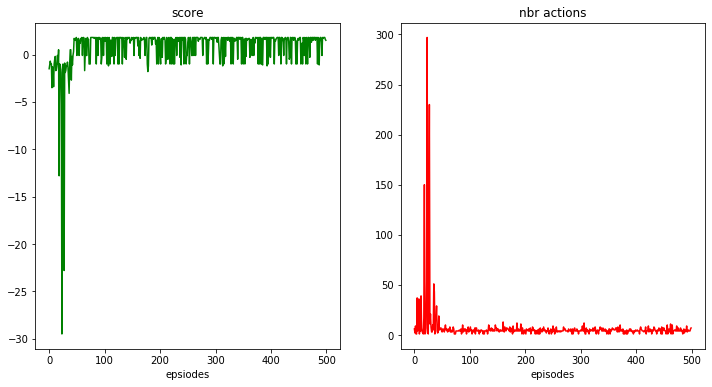

In [103]:
%matplotlib inline

plt.figure(figsize=(12,6))
    


plt.subplot(1,2,1)
plt.plot( np.arange(count_epsds), score_list, "g")
plt.xlabel('epsiodes')
plt.title("score")

plt.subplot(1,2,2)
plt.plot( np.arange(count_epsds), nbr_actions_list,"r")
plt.xlabel('episodes')
plt.title("nbr actions")



plt.show()